# Dataset Challenge

https://physionet.org/content/challenge-2015/1.0.0/

Data are sourced from four hospitals in the USA and Europe.

The full datasetset contains 750 recordings.

An alarm was triggered at the end of these recordings lasting 5 minutes

In [1]:
# Dataset managing tools
import wfdb
import os
from sklearn.utils import class_weight


# Tensorflow
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import optuna

# General
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset_path = "../input/alarm-fatigue/dataset/"

In [3]:
patient = "a103l"

record = wfdb.rdrecord(dataset_path + patient)

# DESCRIZIONE

# Contiene i segnali registrati [riga, colonna] = [tempo, canale]
# record.p_signal 

# Contiene il numero dei segnali registrati
# record.n_sig

# Contiene la frequenza di campionamento
# record.fs

# Contiene il nome della registrazione
# record.record_name

# Contiene la tipologia di allarme e se l'allarme è vero o falso [tipo, V/F] es: ['Asystole', 'False alarm']
# record.comments

# Per altre informazioni
# help(record)

In [4]:
# Get a set of patients

unwanted_files = [".ipynb_checkpo", "AL", "MD5", "REC", "SHA1", "SHA256"]

patient_set = set()
for file in os.listdir(dataset_path):
    if not file[:-4] in unwanted_files:
        patient_set.add(file[:-4])

## Explore dataset

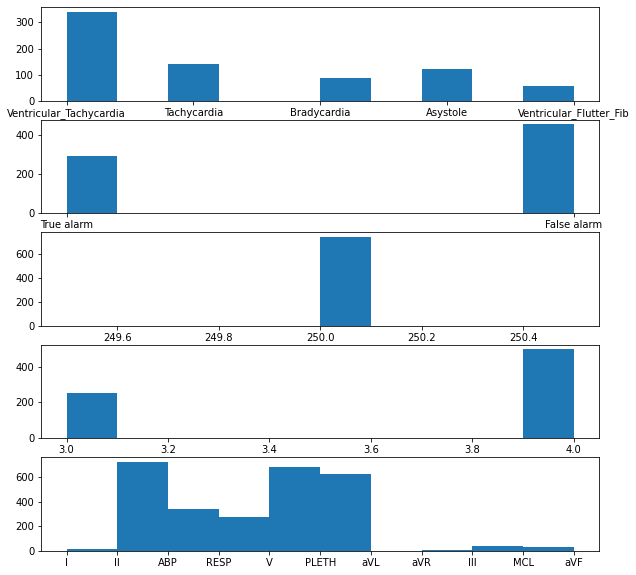

In [5]:
# See which are the labels, the sampling frequency, and the types of alarms

labels_list, fs_list, alert_type_list, n_signal_list, signal_type_list = list(), list(), list(), list(), list()
for patient in patient_set:
    
    # Read the patient record
    record = wfdb.rdrecord(dataset_path + patient)
    
    # Retrieve the information
    fs_list.append(record.fs)
    alert_type_list.append(record.comments[0])
    labels_list.append(record.comments[1])
    n_signal_list.append(record.n_sig)
    for signal_type in record.sig_name:
        signal_type_list.append(signal_type)
    
# Plot 

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,10))

ax[0].hist(alert_type_list)
ax[1].hist(labels_list)
ax[2].hist(fs_list)
ax[3].hist(n_signal_list)
ax[4].hist(signal_type_list)

plt.show()

del labels_list, fs_list, alert_type_list, n_signal_list, signal_type_list

In [6]:
labels_dict, fs_dict, alert_type_dict, signals_dict, n_signals_dict = dict(), dict(), dict(), dict(), dict()
for patient in patient_set:
    
    # Read the patient record
    record = wfdb.rdrecord(dataset_path + patient)
    
    # Retrieve the information
    fs_dict[patient] = record.fs # Sampling frequency
    alert_type_dict[patient] = record.comments[0] # Alert medical condition type
    labels_dict[patient] = record.comments[1] # True/False alarm
    signals_dict[patient] = record.p_signal # Signals
    n_signals_dict[patient] = record.n_sig # Number of signals

In [7]:
# See the proportions between the type of medical condition alarm and the true/false rate

result = dict()

for patient in patient_set:
    
    alert_type = alert_type_dict[patient]
    label = labels_dict[patient]
    
    # Bool correction
    if label == "True alarm":
        label = True
    elif label == "False alarm":
        label = False
    
    
    if alert_type in result.keys():
        previous = result[alert_type]
        previous.append(label)
        result[alert_type] = previous
        
    else:
        result[alert_type] = [label]
        
# Print True/false and proportions
for alert_type in result.keys():
    
    n_trues = np.count_nonzero(result[alert_type])
    n_falses = len(result[alert_type]) - n_trues
    
    print(alert_type, "\n  - True:", n_trues, "\n  - False:", n_falses)
    print("  - Proportions Falses/Total:", np.around(n_falses/(n_falses+n_trues)*100, 2),"%")

del result

Ventricular_Tachycardia 
  - True: 89 
  - False: 252
  - Proportions Falses/Total: 73.9 %
Tachycardia 
  - True: 131 
  - False: 9
  - Proportions Falses/Total: 6.43 %
Bradycardia 
  - True: 46 
  - False: 43
  - Proportions Falses/Total: 48.31 %
Asystole 
  - True: 22 
  - False: 100
  - Proportions Falses/Total: 81.97 %
Ventricular_Flutter_Fib 
  - True: 6 
  - False: 52
  - Proportions Falses/Total: 89.66 %


In [8]:
del labels_dict, fs_dict, alert_type_dict, signals_dict, n_signals_dict

## Selecting only patients with a given set of the same signals

This is done to simplify the problem and to see if the solution is applicable and easy to develop in real life.

Lead II, Lead V and PLETH are the most common type of signals. Thus I consider only the patients having those signals as my dataset

In [9]:
selected_patient_set = set()

for patient in patient_set:
    
    # Read the patient record
    record = wfdb.rdrecord(dataset_path + patient)
    
    # Retrieving what type of signals we have for the selected patient
    signals_names = record.sig_name
    
    if (("II" in signals_names) and ("V" in signals_names) and ("PLETH" in signals_names)):
        selected_patient_set.add(patient)

## Using only training set (validation set is specified later)

In [10]:
# Encoding medical condition as a vector

first_target_encoder =   {"Bradycardia":             [1,0,0,0,0],
                          "Ventricular_Tachycardia": [0,1,0,0,0], 
                          "Asystole":                [0,0,1,0,0], 
                          "Ventricular_Flutter_Fib": [0,0,0,1,0],
                          "Tachycardia":             [0,0,0,0,1]}

## Setting the number of seconds (from the end) that are considered for the time series

In [11]:
# The model receives the last "time_seconds" seconds of the time series data
# If you want to use all the data set time_seconds to None (approx 5 minutes => maximum time_seconds is 300)
time_seconds = 60

### Train

In [12]:
# Creating the train set

train_alert_type, train_labels, train_signals = dict(), dict(), dict()
for patient in selected_patient_set:
    
    # Read the patient record
    record = wfdb.rdrecord(dataset_path + patient)
    
    # Retrieving what type of signals we have for the selected patient
    signals_names = record.sig_name
    
    # Delete unwanted channels
    array = record.p_signal # Signals
    i = 0
    to_delete = list()
    for signal_name in record.sig_name:
        if not signal_name in ["II", "V", "PLETH"]:
            to_delete.append(i)
        i+=1
    for i in to_delete:
        array = np.delete(array, i, 1)
    
    train_signals[patient] = array
    
    # Retrieve the information
    train_alert_type[patient] = first_target_encoder[record.comments[0]] # Alert medical condition type (first targert)
    
    label = record.comments[1]
    
    # Bool encoder
    if label == "True alarm":
        label = 1
    elif label == "False alarm":
        label = 0
        
    train_labels[patient] = label # True/False alarm (second target)
    

In [13]:
# Train
train_signals = list(train_signals.values())

if time_seconds == None:
    # Computing the minimum length of the signal
    minimum = len(train_signals[0])
    for s in train_signals:
        if len(s) < minimum:
            minimum = len(s)
else:   
    # Cutting the array 60 seconds before alarm instead of using all the 5 minutes at my disposal
    minimum = int(250*time_seconds)

# Cutting for having the same array length in input (as they all are 250Hz sampling frequency) from the end (after the end we have the alarm)
for i, signal in enumerate(train_signals):
    train_signals[i] = np.array(signal[-minimum:, :])

X_train = np.array(train_signals)
y1_train = np.array(list(train_alert_type.values()))
y2_train = np.array(list(train_labels.values()))

del train_signals, train_labels, train_alert_type

2022-10-13 16:47:57.954184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 16:47:58.058848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 16:47:58.059709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 16:47:58.061490: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

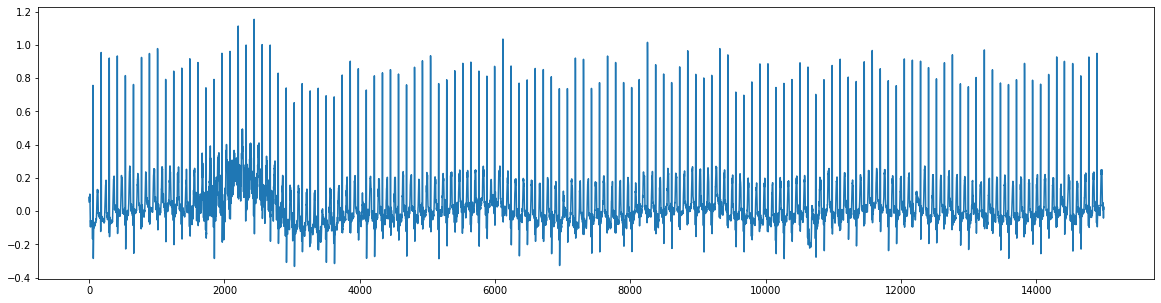

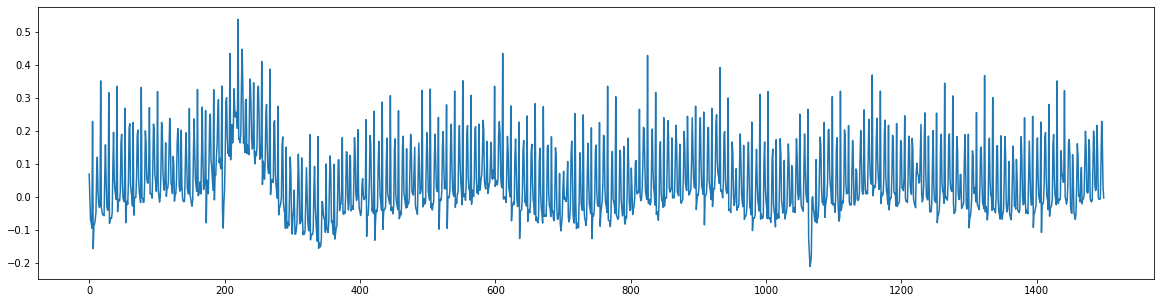

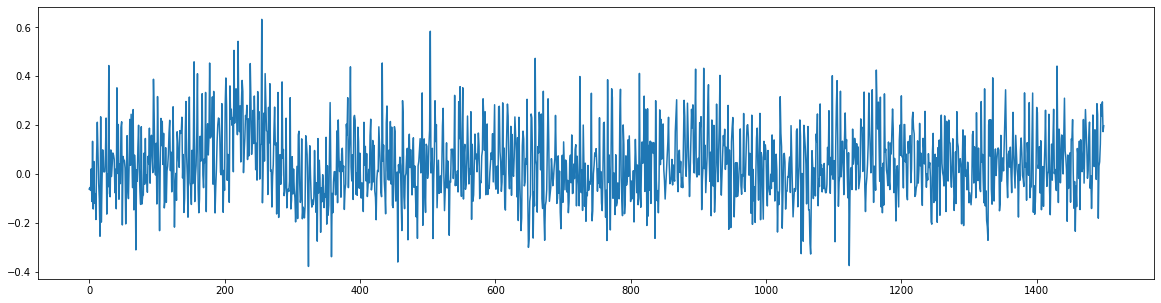

In [14]:
signal = X_train[10].transpose()[1]
decimated_signal = tfkl.AveragePooling1D(pool_size=10, strides=10)(tf.reshape(signal, [1, len(signal), 1]))

plt.figure(figsize=(20,5))
plt.plot(signal)
plt.show()

plt.figure(figsize=(20,5))
plt.plot(np.array(decimated_signal).flatten())
plt.show()

plt.figure(figsize=(20,5))
plt.plot(np.array(decimated_signal).flatten() + np.random.normal(0, 0.1, size=len(np.array(decimated_signal).flatten())))
plt.show()

## Taking care of NaNs in the signals

In [15]:
# the following patients present nan values
np.unique(np.argwhere(np.isnan(X_train) != False).transpose()[0])

array([ 15,  41,  64, 102, 135, 142, 145, 149, 152, 154, 159, 161, 170,
       171, 176, 178, 182, 190, 199, 202, 212, 249, 250, 255, 260, 264,
       265, 270, 275, 292, 297, 312, 321, 337, 347, 355, 360, 376, 377,
       388, 435, 441, 457, 468, 477, 495, 498, 541, 543, 550, 569, 570])

In [16]:
# Count how manyn nans we have in the dataset
np.count_nonzero(np.isnan(X_train))

255148

In [17]:
def replace_nans(X_train_n):
    
    #osservazioni (n), sample (j), segnale (i)
    # segnale 0 -........
    # segnale 1 ---..,.-
    # segnale 2 .-.-....-.
    
    for i, signal in enumerate(X_train_n.transpose()):
    
        nan_position = np.argwhere(np.isnan(signal)).transpose()[0]
        #print(nan_position)

        # j contains the argument (position) of where it is nan
        for j in nan_position:
            if (j == 0):
                X_train_n[j][i] = 0
                #print("A", X_train_n[j][i])
            else:
                X_train_n[j][i] = X_train_n[j-1][i]
                #print("B", X_train_n[j][i])
                
    return X_train_n

In [18]:
for n, X_train_n in enumerate(X_train):
    X_train[n] = replace_nans(X_train_n)

In [19]:
# the following patients present nan values
np.unique(np.argwhere(np.isnan(X_train) != False).transpose()[0])

array([], dtype=int64)

In [20]:
# Count how manyn nans we have in the dataset
np.count_nonzero(np.isnan(X_train))

0

## Predict the True/False label (False Alarm vs True Alarm)

In [53]:
# Defining model

def build_model(input_shape, output_shape, lr, n_dense_neurons):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Decimate input for aster computing time
    x = tfkl.AveragePooling1D(pool_size=10, strides=10)(input_layer)
    
    # Normalization and gaussian noise
    x = tfkl.BatchNormalization()(x)
    x = tfkl.GaussianNoise(stddev=0.07)(x)
    
    #x = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences = True))(x)
    
    x = tfkl.Conv1D(128, 10, padding='same', activation='relu', strides=1)(x)
    x = tfkl.MaxPool1D(pool_size=8)(x)
    
    x = tfkl.Conv1D(256, 5, padding='same', activation='tanh', strides=1)(x)
    x = tfkl.MaxPool1D(pool_size=8)(x)
    
    x = tfkl.Conv1D(512, 3, padding='same', activation='tanh', strides=1)(x)
    x = tfkl.MaxPool1D(pool_size=8)(x)
    
    x = tfkl.Flatten()(x)
    
    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    
    # Dense 1
    x = tfkl.Dense(n_dense_neurons[0], activation='relu')(x) 
    
    # Dense 2
    x = tfkl.Dense(n_dense_neurons[1], activation='relu')(x)
    x = tfkl.BatchNormalization()(x) 
    
    # Dense 3
    x = tfkl.Dense(n_dense_neurons[2], activation='relu')(x)
    x = tfkl.BatchNormalization()(x) 
    
    output_layer = tfkl.Dense(output_shape, activation='sigmoid')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics=['Accuracy', 'FalseNegatives', 'FalsePositives'])

    # Return the model
    return model

In [54]:
# Defining fixed model parameters
input_shape = X_train.shape[1:]
output_shape = 1
epochs = 50

# Building the model defined above
model = build_model(input_shape, output_shape, 1e-3, [512, 256, 128]) 
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 15000, 3)]        0         
_________________________________________________________________
average_pooling1d_232 (Avera (None, 1500, 3)           0         
_________________________________________________________________
batch_normalization_689 (Bat (None, 1500, 3)           12        
_________________________________________________________________
gaussian_noise_231 (Gaussian (None, 1500, 3)           0         
_________________________________________________________________
conv1d_688 (Conv1D)          (None, 1500, 128)         3968      
_________________________________________________________________
max_pooling1d_687 (MaxPoolin (None, 187, 128)          0         
_________________________________________________________________
conv1d_689 (Conv1D)          (None, 187, 256)          164096

In [55]:
# Number of observation of classes
n_ones = np.count_nonzero(y2_train)
n_zeros = len(y2_train) - np.count_nonzero(y2_train)

n_ones, n_zeros

(202, 370)

In [62]:
# X tensor is in the format like (observation, time, channel)

# Defining fixed model parameters
input_shape = X_train.shape[1:]
output_shape = 1
epochs = 30

# Classed weight for class imbalance
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y2_train),
                                                 y = y2_train)
class_weights = dict(zip(np.unique(y2_train), class_weights))

# Computing a validation population
validation_percentage = 0.25
total_population = len(X_train)


# Hyperparameters search
def objective(trial):
    
    # Hyperparameters
    batch_size = trial.suggest_int("batch_size", 8, 128, step=8)
    n_dense_neurons = [trial.suggest_int("dense 1", 256, 512, step=32),
                       trial.suggest_int("dense 2", 128, 256, step=32),
                       trial.suggest_int("dense 3", 64, 128, step=32)]
    lr = trial.suggest_float("lr", 1e-4, 1e-3)
    
    # Building the model defined above
    model = build_model(input_shape, output_shape, lr, n_dense_neurons) 
    
    # Fitting the model
    model_history = model.fit(
        x = X_train,
        y = y2_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_split = validation_percentage,
        class_weight = class_weights,
        callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)],
        verbose=0).history
    
    # Retrieving validation accuracy
    last_validation_accuracy = model_history["val_Accuracy"][-1]
    last_validation_false_negatives = model_history["val_false_negatives"][-1]
    last_validation_false_positives = model_history["val_false_positives"][-1]
    
    # Printing Accuracy
    print("Accuracy:", np.around(last_validation_accuracy*100, 2), "% -", 
          "FN:", np.around(last_validation_false_negatives/(validation_percentage*total_population)*100, 2), "% - ",
          "FP:", np.around(last_validation_false_positives/(validation_percentage*total_population)*100, 2), "%"
         )
    
    # Scoring function to maximize (In theory I would like to minimize the number of false positives -> for now we can maximise the accuracy)
    score = (1/(1+last_validation_accuracy))
    
    return score

# Optimizing the hyperparams
study = optuna.create_study()
study.optimize(objective, n_trials=50)

# Printing the best study parameters
print("\n - The best study is number:", study.best_trial.number)
print("\n - The best study hyperparameters are:", study.best_params)  

[I 2022-10-13 17:24:17,872] A new study created in memory with name: no-name-5217a435-5bd2-4f2c-a332-1e8c009fc68c
[I 2022-10-13 17:24:22,491] Trial 0 finished with value: 0.5909090845052861 and parameters: {'batch_size': 88, 'dense 1': 512, 'dense 2': 128, 'dense 3': 96, 'lr': 0.0006174279949703399}. Best is trial 0 with value: 0.5909090845052861.


Accuracy: 69.23 % - FN: 20.28 % -  FP: 10.49 %


[I 2022-10-13 17:24:30,109] Trial 1 finished with value: 0.5909090845052861 and parameters: {'batch_size': 8, 'dense 1': 352, 'dense 2': 192, 'dense 3': 96, 'lr': 0.00021787886268556374}. Best is trial 0 with value: 0.5909090845052861.


Accuracy: 69.23 % - FN: 6.29 % -  FP: 24.48 %


[I 2022-10-13 17:24:39,272] Trial 2 finished with value: 0.6470588167233451 and parameters: {'batch_size': 16, 'dense 1': 448, 'dense 2': 128, 'dense 3': 128, 'lr': 0.0004469276874458926}. Best is trial 0 with value: 0.5909090845052861.


Accuracy: 54.55 % - FN: 1.4 % -  FP: 44.06 %


[I 2022-10-13 17:24:45,801] Trial 3 finished with value: 0.5958333399922898 and parameters: {'batch_size': 16, 'dense 1': 448, 'dense 2': 160, 'dense 3': 64, 'lr': 0.0009728188924504345}. Best is trial 0 with value: 0.5909090845052861.


Accuracy: 67.83 % - FN: 24.48 % -  FP: 7.69 %


[I 2022-10-13 17:24:53,016] Trial 4 finished with value: 0.569721123114141 and parameters: {'batch_size': 8, 'dense 1': 448, 'dense 2': 160, 'dense 3': 64, 'lr': 0.0004989571219568796}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 75.52 % - FN: 20.28 % -  FP: 4.2 %


[I 2022-10-13 17:25:00,930] Trial 5 finished with value: 0.5909090845052861 and parameters: {'batch_size': 64, 'dense 1': 288, 'dense 2': 192, 'dense 3': 64, 'lr': 0.0008981367079223819}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.23 % - FN: 18.88 % -  FP: 11.89 %


[I 2022-10-13 17:25:06,374] Trial 6 finished with value: 0.6033755219632767 and parameters: {'batch_size': 16, 'dense 1': 416, 'dense 2': 224, 'dense 3': 64, 'lr': 0.00046789713785693496}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 65.73 % - FN: 6.99 % -  FP: 27.27 %


[I 2022-10-13 17:25:11,054] Trial 7 finished with value: 0.5884773638012686 and parameters: {'batch_size': 16, 'dense 1': 512, 'dense 2': 160, 'dense 3': 64, 'lr': 0.00022007888713596158}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.93 % - FN: 6.99 % -  FP: 23.08 %


[I 2022-10-13 17:25:17,341] Trial 8 finished with value: 0.5909090845052861 and parameters: {'batch_size': 64, 'dense 1': 480, 'dense 2': 256, 'dense 3': 64, 'lr': 0.0004058967657171358}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.23 % - FN: 20.98 % -  FP: 9.79 %


[I 2022-10-13 17:25:20,891] Trial 9 finished with value: 0.5860655752021406 and parameters: {'batch_size': 56, 'dense 1': 448, 'dense 2': 160, 'dense 3': 128, 'lr': 0.00019169618280088713}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 70.63 % - FN: 17.48 % -  FP: 11.89 %


[I 2022-10-13 17:25:25,269] Trial 10 finished with value: 0.6059321937485953 and parameters: {'batch_size': 128, 'dense 1': 352, 'dense 2': 224, 'dense 3': 96, 'lr': 0.00071344758215906}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 65.03 % - FN: 34.97 % -  FP: 0.0 %


[I 2022-10-13 17:25:28,978] Trial 11 finished with value: 0.5958333399922898 and parameters: {'batch_size': 48, 'dense 1': 384, 'dense 2': 160, 'dense 3': 128, 'lr': 0.00012020402453479033}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 67.83 % - FN: 13.99 % -  FP: 18.18 %


[I 2022-10-13 17:25:32,807] Trial 12 finished with value: 0.5909090845052861 and parameters: {'batch_size': 40, 'dense 1': 416, 'dense 2': 160, 'dense 3': 128, 'lr': 0.00031689679386577845}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.23 % - FN: 6.99 % -  FP: 23.78 %


[I 2022-10-13 17:25:36,561] Trial 13 finished with value: 0.5983263625185545 and parameters: {'batch_size': 88, 'dense 1': 256, 'dense 2': 128, 'dense 3': 128, 'lr': 0.0007096035801243087}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 67.13 % - FN: 29.37 % -  FP: 3.5 %


[I 2022-10-13 17:25:40,630] Trial 14 finished with value: 0.6085106464779286 and parameters: {'batch_size': 104, 'dense 1': 448, 'dense 2': 192, 'dense 3': 96, 'lr': 0.00010719645614130841}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 64.34 % - FN: 35.66 % -  FP: 0.0 %


[I 2022-10-13 17:25:44,297] Trial 15 finished with value: 0.5813008220223035 and parameters: {'batch_size': 48, 'dense 1': 480, 'dense 2': 160, 'dense 3': 96, 'lr': 0.0005604508866527387}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 72.03 % - FN: 13.99 % -  FP: 13.99 %


[I 2022-10-13 17:25:48,829] Trial 16 finished with value: 0.5909090845052861 and parameters: {'batch_size': 32, 'dense 1': 480, 'dense 2': 224, 'dense 3': 96, 'lr': 0.0005954721202829122}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.23 % - FN: 18.18 % -  FP: 12.59 %


[I 2022-10-13 17:25:52,767] Trial 17 finished with value: 0.6033755219632767 and parameters: {'batch_size': 32, 'dense 1': 384, 'dense 2': 128, 'dense 3': 64, 'lr': 0.0007397736254883424}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 65.73 % - FN: 6.29 % -  FP: 27.97 %


[I 2022-10-13 17:25:56,537] Trial 18 finished with value: 0.5836734746417023 and parameters: {'batch_size': 80, 'dense 1': 480, 'dense 2': 160, 'dense 3': 96, 'lr': 0.000505735762534213}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 71.33 % - FN: 23.08 % -  FP: 5.59 %


[I 2022-10-13 17:26:00,837] Trial 19 finished with value: 0.6008403347801854 and parameters: {'batch_size': 32, 'dense 1': 512, 'dense 2': 192, 'dense 3': 96, 'lr': 0.0003854014542988256}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 66.43 % - FN: 6.99 % -  FP: 26.57 %


[I 2022-10-13 17:26:05,070] Trial 20 finished with value: 0.576612899761209 and parameters: {'batch_size': 48, 'dense 1': 416, 'dense 2': 192, 'dense 3': 64, 'lr': 0.0005693372109570526}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 73.43 % - FN: 10.49 % -  FP: 16.08 %


[I 2022-10-13 17:26:09,222] Trial 21 finished with value: 0.5884773638012686 and parameters: {'batch_size': 48, 'dense 1': 416, 'dense 2': 192, 'dense 3': 64, 'lr': 0.0005634762820700487}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.93 % - FN: 13.29 % -  FP: 16.78 %


[I 2022-10-13 17:26:12,709] Trial 22 finished with value: 0.5860655752021406 and parameters: {'batch_size': 80, 'dense 1': 416, 'dense 2': 192, 'dense 3': 64, 'lr': 0.0006565029050304952}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 70.63 % - FN: 15.38 % -  FP: 13.99 %


[I 2022-10-13 17:26:16,915] Trial 23 finished with value: 0.5813008220223035 and parameters: {'batch_size': 48, 'dense 1': 352, 'dense 2': 160, 'dense 3': 64, 'lr': 0.0008446633774790732}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 72.03 % - FN: 16.08 % -  FP: 11.89 %


[I 2022-10-13 17:26:20,346] Trial 24 finished with value: 0.5983263625185545 and parameters: {'batch_size': 112, 'dense 1': 320, 'dense 2': 224, 'dense 3': 64, 'lr': 0.0007892263938958458}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 67.13 % - FN: 32.87 % -  FP: 0.0 %


[I 2022-10-13 17:26:24,383] Trial 25 finished with value: 0.5884773638012686 and parameters: {'batch_size': 72, 'dense 1': 480, 'dense 2': 256, 'dense 3': 96, 'lr': 0.0003324857750936145}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.93 % - FN: 19.58 % -  FP: 10.49 %


[I 2022-10-13 17:26:29,760] Trial 26 finished with value: 0.5836734746417023 and parameters: {'batch_size': 32, 'dense 1': 352, 'dense 2': 160, 'dense 3': 64, 'lr': 0.0008820426309585526}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 71.33 % - FN: 9.09 % -  FP: 19.58 %


[I 2022-10-13 17:26:37,793] Trial 27 finished with value: 0.7333333275053237 and parameters: {'batch_size': 8, 'dense 1': 320, 'dense 2': 128, 'dense 3': 64, 'lr': 0.0008347569091516347}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 36.36 % - FN: 0.0 % -  FP: 63.64 %


[I 2022-10-13 17:26:41,376] Trial 28 finished with value: 0.5933609854312779 and parameters: {'batch_size': 56, 'dense 1': 448, 'dense 2': 192, 'dense 3': 96, 'lr': 0.0005077971174840723}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 68.53 % - FN: 6.99 % -  FP: 24.48 %


[I 2022-10-13 17:26:45,297] Trial 29 finished with value: 0.6033755219632767 and parameters: {'batch_size': 96, 'dense 1': 384, 'dense 2': 128, 'dense 3': 64, 'lr': 0.0006428492275902729}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 65.73 % - FN: 30.07 % -  FP: 4.2 %


[I 2022-10-13 17:26:50,007] Trial 30 finished with value: 0.576612899761209 and parameters: {'batch_size': 24, 'dense 1': 320, 'dense 2': 160, 'dense 3': 64, 'lr': 0.0009443961287695685}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 73.43 % - FN: 11.19 % -  FP: 15.38 %


[I 2022-10-13 17:26:56,388] Trial 31 finished with value: 0.5958333399922898 and parameters: {'batch_size': 40, 'dense 1': 320, 'dense 2': 160, 'dense 3': 64, 'lr': 0.0009903419779132554}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 67.83 % - FN: 14.69 % -  FP: 17.48 %


[I 2022-10-13 17:27:00,887] Trial 32 finished with value: 0.5909090845052861 and parameters: {'batch_size': 24, 'dense 1': 512, 'dense 2': 192, 'dense 3': 64, 'lr': 0.0005307758533379723}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.23 % - FN: 4.9 % -  FP: 25.87 %


[I 2022-10-13 17:27:10,202] Trial 33 finished with value: 0.7333333275053237 and parameters: {'batch_size': 8, 'dense 1': 352, 'dense 2': 160, 'dense 3': 64, 'lr': 0.000926179271310459}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 36.36 % - FN: 0.0 % -  FP: 63.64 %


[I 2022-10-13 17:27:14,530] Trial 34 finished with value: 0.5884773638012686 and parameters: {'batch_size': 24, 'dense 1': 288, 'dense 2': 128, 'dense 3': 64, 'lr': 0.0008388468424613473}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.93 % - FN: 13.29 % -  FP: 16.78 %


[I 2022-10-13 17:27:21,162] Trial 35 finished with value: 0.5983263625185545 and parameters: {'batch_size': 24, 'dense 1': 384, 'dense 2': 160, 'dense 3': 64, 'lr': 0.0009264727679410509}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 67.13 % - FN: 26.57 % -  FP: 6.29 %


[I 2022-10-13 17:27:30,692] Trial 36 finished with value: 0.6008403347801854 and parameters: {'batch_size': 8, 'dense 1': 288, 'dense 2': 160, 'dense 3': 64, 'lr': 0.0007810504137522839}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 66.43 % - FN: 11.89 % -  FP: 21.68 %


[I 2022-10-13 17:27:39,269] Trial 37 finished with value: 0.6008403347801854 and parameters: {'batch_size': 40, 'dense 1': 320, 'dense 2': 224, 'dense 3': 64, 'lr': 0.0009643474248269957}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 66.43 % - FN: 6.99 % -  FP: 26.57 %


[I 2022-10-13 17:27:43,025] Trial 38 finished with value: 0.5860655752021406 and parameters: {'batch_size': 56, 'dense 1': 256, 'dense 2': 192, 'dense 3': 64, 'lr': 0.0004469486676004032}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 70.63 % - FN: 6.99 % -  FP: 22.38 %


[I 2022-10-13 17:27:49,037] Trial 39 finished with value: 0.5909090845052861 and parameters: {'batch_size': 16, 'dense 1': 352, 'dense 2': 128, 'dense 3': 64, 'lr': 0.0006851401011178134}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.23 % - FN: 20.28 % -  FP: 10.49 %


[I 2022-10-13 17:27:52,596] Trial 40 finished with value: 0.6059321937485953 and parameters: {'batch_size': 64, 'dense 1': 384, 'dense 2': 160, 'dense 3': 64, 'lr': 0.0008358958325223099}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 65.03 % - FN: 6.99 % -  FP: 27.97 %


[I 2022-10-13 17:27:57,335] Trial 41 finished with value: 0.6217391402633521 and parameters: {'batch_size': 24, 'dense 1': 416, 'dense 2': 160, 'dense 3': 96, 'lr': 0.0005875013595956264}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 60.84 % - FN: 3.5 % -  FP: 35.66 %


[I 2022-10-13 17:28:03,588] Trial 42 finished with value: 0.5836734746417023 and parameters: {'batch_size': 48, 'dense 1': 448, 'dense 2': 160, 'dense 3': 64, 'lr': 0.00039964417537004205}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 71.33 % - FN: 11.19 % -  FP: 17.48 %


[I 2022-10-13 17:28:07,373] Trial 43 finished with value: 0.5884773638012686 and parameters: {'batch_size': 48, 'dense 1': 448, 'dense 2': 160, 'dense 3': 96, 'lr': 0.0003460037652996587}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.93 % - FN: 9.79 % -  FP: 20.28 %


[I 2022-10-13 17:28:11,308] Trial 44 finished with value: 0.6008403347801854 and parameters: {'batch_size': 40, 'dense 1': 480, 'dense 2': 192, 'dense 3': 128, 'lr': 0.0004978839935608095}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 66.43 % - FN: 11.19 % -  FP: 22.38 %


[I 2022-10-13 17:28:16,855] Trial 45 finished with value: 0.6008403347801854 and parameters: {'batch_size': 16, 'dense 1': 416, 'dense 2': 128, 'dense 3': 64, 'lr': 0.0006205701528571981}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 66.43 % - FN: 9.09 % -  FP: 24.48 %


[I 2022-10-13 17:28:20,399] Trial 46 finished with value: 0.5860655752021406 and parameters: {'batch_size': 64, 'dense 1': 448, 'dense 2': 160, 'dense 3': 64, 'lr': 0.00026435271894171956}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 70.63 % - FN: 18.18 % -  FP: 11.19 %


[I 2022-10-13 17:28:24,133] Trial 47 finished with value: 0.5813008220223035 and parameters: {'batch_size': 56, 'dense 1': 288, 'dense 2': 192, 'dense 3': 96, 'lr': 0.00046790997363781503}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 72.03 % - FN: 12.59 % -  FP: 15.38 %


[I 2022-10-13 17:28:28,237] Trial 48 finished with value: 0.5909090845052861 and parameters: {'batch_size': 72, 'dense 1': 512, 'dense 2': 160, 'dense 3': 128, 'lr': 0.0007532834213223355}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 69.23 % - FN: 20.98 % -  FP: 9.79 %


[I 2022-10-13 17:28:32,364] Trial 49 finished with value: 0.5958333399922898 and parameters: {'batch_size': 56, 'dense 1': 288, 'dense 2': 192, 'dense 3': 96, 'lr': 0.0004641973045114528}. Best is trial 4 with value: 0.569721123114141.


Accuracy: 67.83 % - FN: 9.09 % -  FP: 23.08 %

 - The best study is number: 4

 - The best study hyperparameters are: {'batch_size': 8, 'dense 1': 448, 'dense 2': 160, 'dense 3': 64, 'lr': 0.0004989571219568796}
